/opt/miniconda3/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/test/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/miniconda3/envs/test/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


/opt/miniconda3/envs/test/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/miniconda3/envs/test/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/miniconda3/envs/test/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/miniconda3/envs/test/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/miniconda3/envs/test/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/

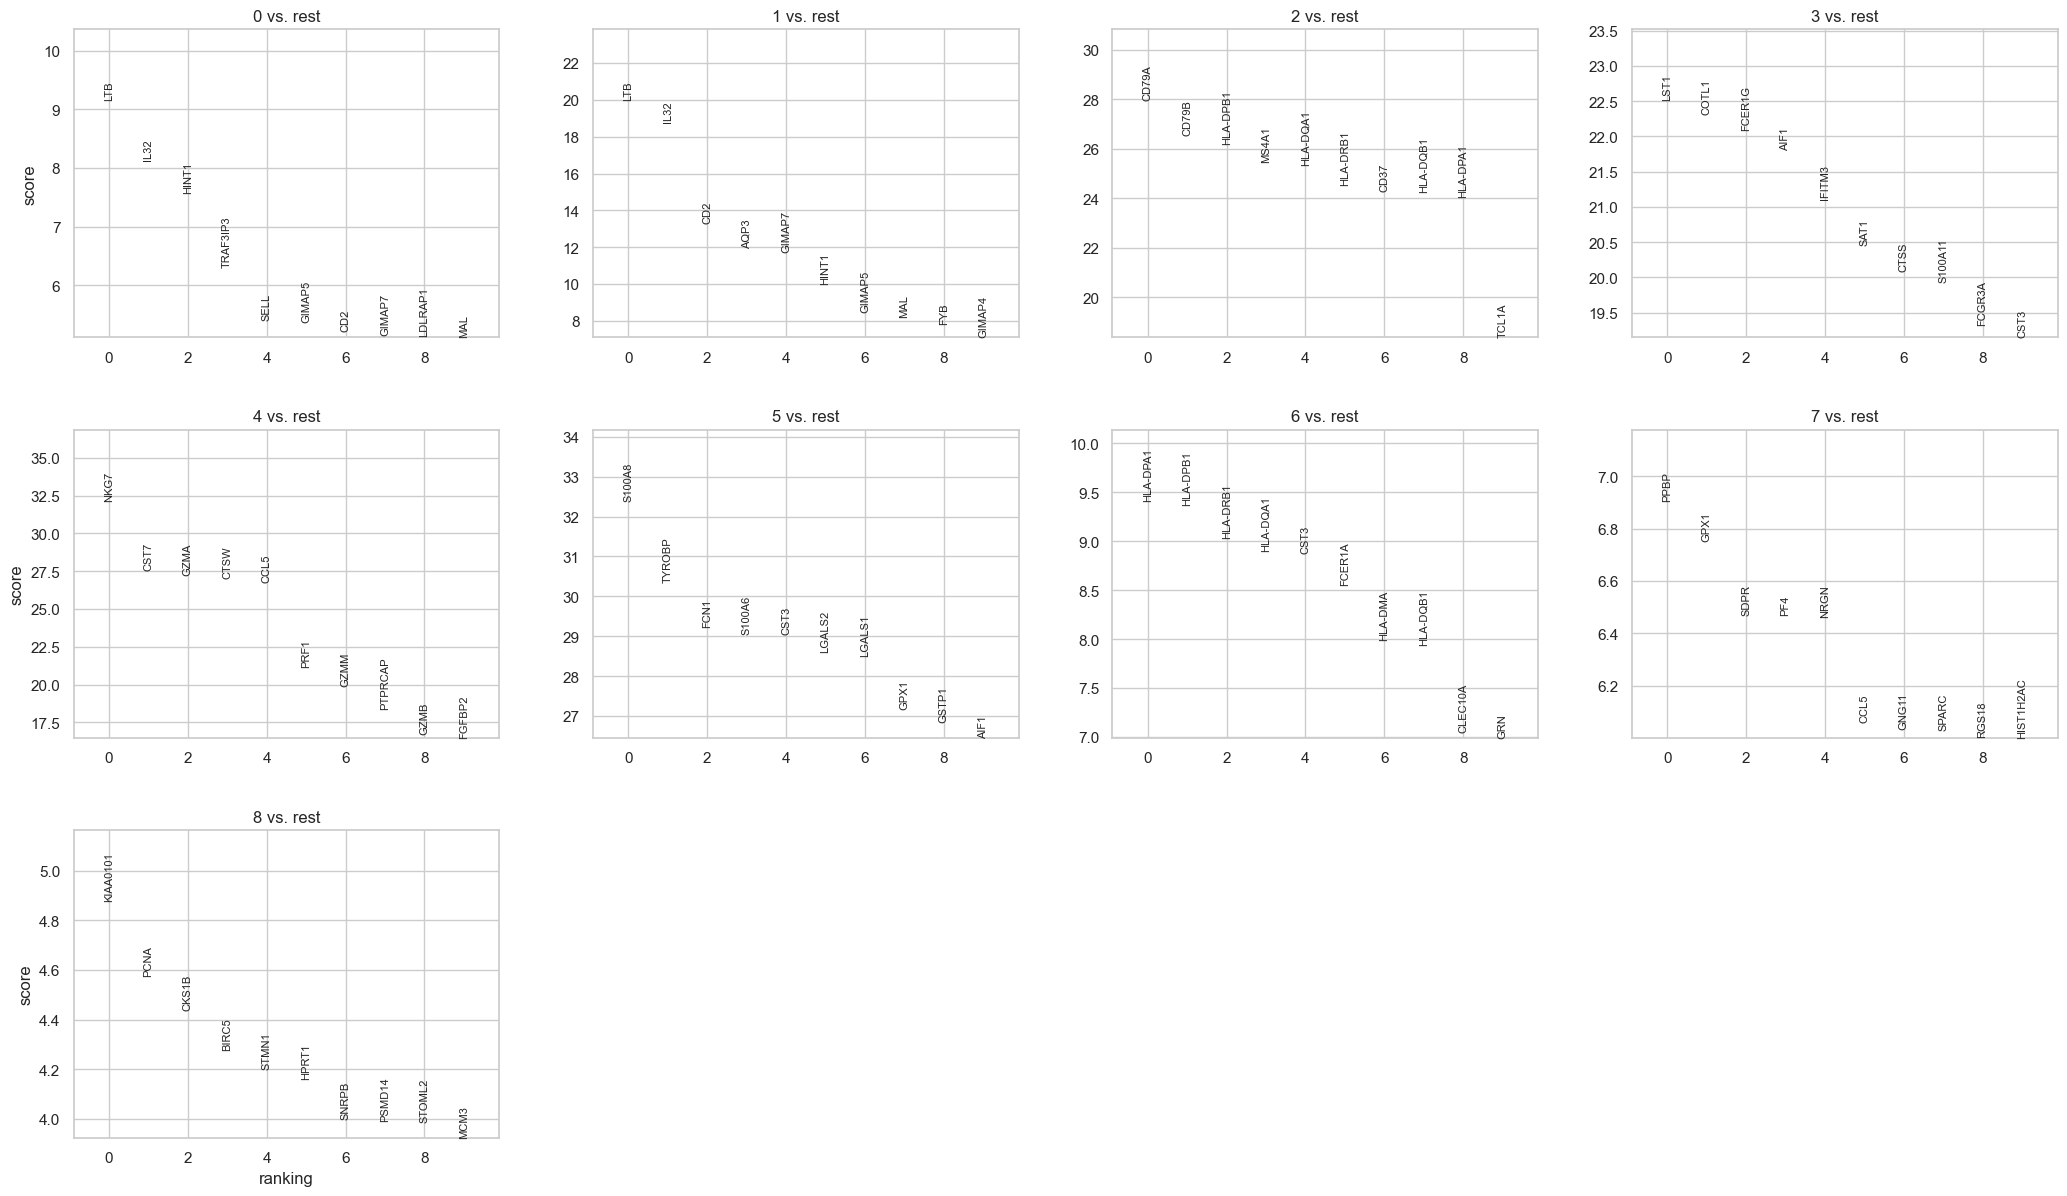

Report saved to figures/cluster_annotations_and_top_genes.md


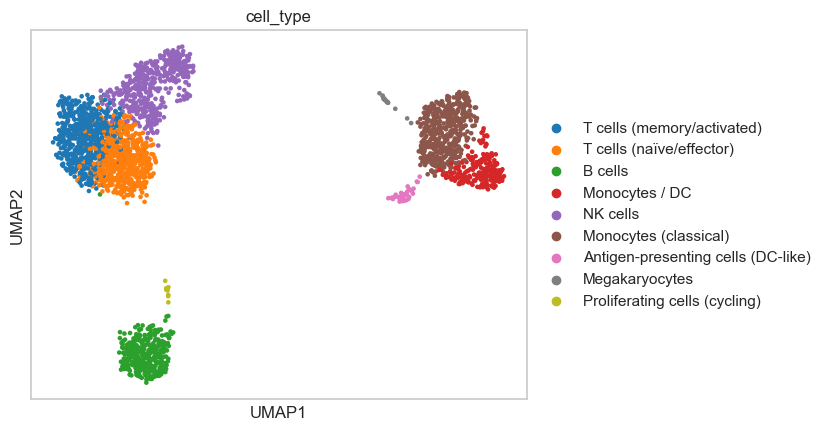

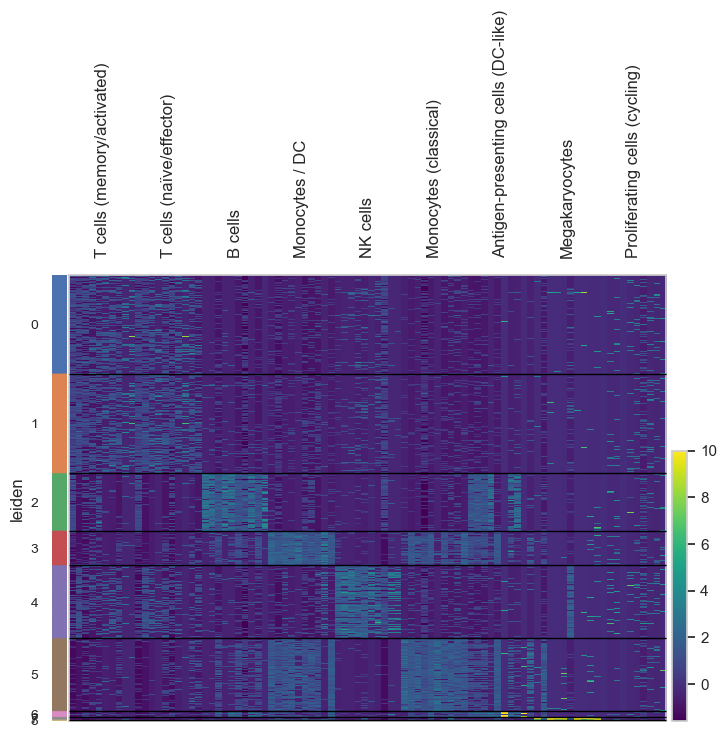

Random Forest AUC: 0.9830


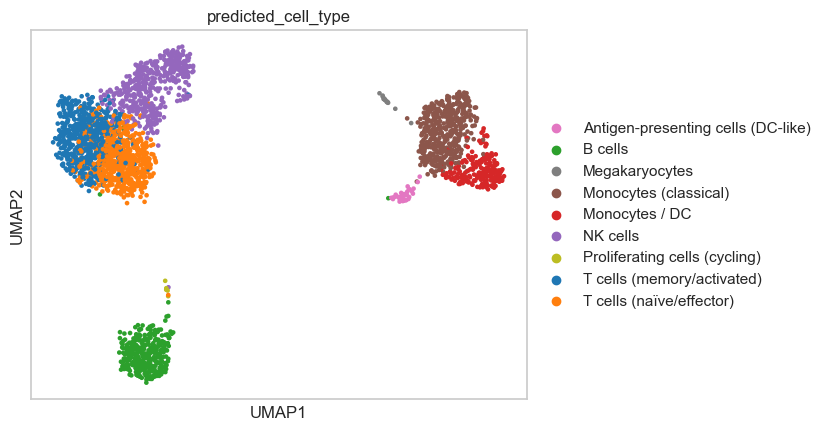

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import shap

# Configuration
FIGURES_DIR = "figures"
sc.settings.figdir = FIGURES_DIR
os.makedirs(FIGURES_DIR, exist_ok=True)
sns.set_theme(style='whitegrid')

def load_and_preprocess_data(data_path):
    """Load and preprocess scRNA-seq data from 10x Genomics format."""
    adata = sc.read_10x_mtx(
        data_path,
        var_names='gene_symbols',
        cache=True
    )
    adata.var_names_make_unique()
    
    # Filter low-quality cells and genes
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    # Normalize and log-transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Select highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata = adata[:, adata.var.highly_variable]
    
    # Scale data
    sc.pp.scale(adata, max_value=10)
    
    return adata

def perform_dimensionality_reduction(adata):
    """Perform PCA, neighbor computation, and UMAP for clustering."""
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.9, flavor='igraph', n_iterations=2, directed=False)
    return adata

def identify_marker_genes(adata):
    """Identify and visualize marker genes for each cluster."""
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
    sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False, save='_ranked_genes.png')
    plt.close()
    
    # Extract top genes per cluster
    cluster_top = {
        group: adata.uns['rank_genes_groups']['names'][group][:10]
        for group in adata.uns['rank_genes_groups']['names'].dtype.names
    }
    return cluster_top

def annotate_clusters(adata):
    """Annotate clusters with cell type labels."""
    cluster_annotations = {
        '0': 'T cells (memory/activated)',
        '1': 'T cells (naïve/effector)',
        '2': 'B cells',
        '3': 'Monocytes / DC',
        '4': 'NK cells',
        '5': 'Monocytes (classical)',
        '6': 'Antigen-presenting cells (DC-like)',
        '7': 'Megakaryocytes',
        '8': 'Proliferating cells (cycling)'
    }
    adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations).astype('category')
    return adata, cluster_annotations

def create_markdown_report(cluster_top, cluster_annotations):
    """Generate a Markdown report summarizing cluster annotations and top genes."""
    table_md = [
        [cluster, cluster_annotations.get(cluster, 'Unknown'), ', '.join(genes)]
        for cluster, genes in cluster_top.items()
    ]
    df = pd.DataFrame(table_md, columns=["Cluster", "Cell Type", "Top Genes"])
    
    report_path = os.path.join(FIGURES_DIR, "cluster_annotations_and_top_genes.md")
    with open(report_path, "w") as f:
        f.write("# 🧬 scRNA-seq Analysis Report: PBMC3k\n\n")
        f.write("## Cluster Annotations and Top Marker Genes\n\n")
        f.write(df.to_markdown(index=False))
    print(f"Report saved to {report_path}")
    return df

def visualize_clusters(adata, palette):
    """Visualize UMAP with annotated cell types."""
    sc.pl.umap(adata, color=['cell_type'], palette=palette, save='_clusters.png')
    plt.close()

def validate_markers(adata, markers):
    """Check for missing marker genes in the dataset."""
    for cell_type, genes in markers.items():
        missing_genes = [gene for gene in genes if gene not in adata.var_names]
        if missing_genes:
            print(f"Warning: Missing markers for {cell_type}: {', '.join(missing_genes)}")

def plot_marker_heatmap(adata, markers):
    """Generate a heatmap of marker gene expression."""
    sc.pl.heatmap(adata, markers, groupby='leiden', use_raw=False, cmap='viridis', save='_marker_heatmap.png')
    plt.close()

def train_random_forest(adata, markers, palette):
    """Train and evaluate a Random Forest classifier for cell type prediction."""
    marker_genes = [gene for genes in markers.values() for gene in genes if gene in adata.var_names]
    X = adata[:, marker_genes].X
    y = adata.obs['cell_type'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_prob = rf.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    print(f"Random Forest AUC: {auc:.4f}")
    
    # Predict on full dataset for visualization
    adata.obs['predicted_cell_type'] = rf.predict(adata[:, marker_genes].X)
    sc.pl.umap(adata, color=['predicted_cell_type'], palette=palette, save='_predicted_cell_types.png')
    plt.close()
    
    return rf, X_test, marker_genes

def explain_model(rf, X_test, marker_genes):
    """Generate SHAP summary plot for Random Forest model."""
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=marker_genes, plot_type='bar', max_display=20, show=False)
    plt.savefig(os.path.join(FIGURES_DIR, "shap_summary_plot.png"))
    plt.close()

def main():
    """Main function to execute the scRNA-seq analysis pipeline."""
    # Define color palette
    cell_type_palette = {
        'T cells (memory/activated)': '#1f77b4',
        'T cells (naïve/effector)': '#ff7f0e',
        'B cells': '#2ca02c',
        'Monocytes / DC': '#d62728',
        'NK cells': '#9467bd',
        'Monocytes (classical)': '#8c564b',
        'Antigen-presenting cells (DC-like)': '#e377c2',
        'Megakaryocytes': '#7f7f7f',
        'Proliferating cells (cycling)': '#bcbd22'
    }
    
    # Define marker genes
    markers = {
        'T cells (memory/activated)': ['LTB', 'IL32', 'HINT1', 'TRAF3IP3', 'SELL', 'GIMAP5', 'CD2', 'GIMAP7', 'LDLRAP1', 'MAL'],
        'T cells (naïve/effector)': ['LTB', 'IL32', 'CD2', 'AQP3', 'GIMAP7', 'HINT1', 'GIMAP5', 'MAL', 'FYB', 'GIMAP4'],
        'B cells': ['CD79A', 'CD79B', 'HLA-DPB1', 'MS4A1', 'HLA-DQA1', 'HLA-DRB1', 'CD37', 'HLA-DQB1', 'HLA-DPA1', 'TCL1A'],
        'Monocytes / DC': ['LST1', 'COTL1', 'FCER1G', 'AIF1', 'IFITM3', 'SAT1', 'CTSS', 'S100A11', 'FCGR3A', 'CST3'],
        'NK cells': ['NKG7', 'CST7', 'GZMA', 'CTSW', 'CCL5', 'PRF1', 'GZMM', 'PTPRCAP', 'GZMB', 'FGFBP2'],
        'Monocytes (classical)': ['S100A8', 'TYROBP', 'FCN1', 'S100A6', 'CST3', 'LGALS2', 'LGALS1', 'GPX1', 'GSTP1', 'AIF1'],
        'Antigen-presenting cells (DC-like)': ['HLA-DPA1', 'HLA-DPB1', 'HLA-DRB1', 'HLA-DQA1', 'CST3', 'FCER1A', 'HLA-DMA', 'HLA-DQB1', 'CLEC10A', 'GRN'],
        'Megakaryocytes': ['PPBP', 'GPX1', 'SDPR', 'PF4', 'NRGN', 'CCL5', 'GNG11', 'SPARC', 'RGS18', 'HIST1H2AC'],
        'Proliferating cells (cycling)': ['KIAA0101', 'PCNA', 'CKS1B', 'BIRC5', 'STMN1', 'HPRT1', 'SNRPB', 'PSMD14', 'STOML2', 'MCM3']
    }
    
    # Execute pipeline
    adata = load_and_preprocess_data('data/filtered_gene_bc_matrices/hg19')
    adata = perform_dimensionality_reduction(adata)
    cluster_top = identify_marker_genes(adata)
    adata, cluster_annotations = annotate_clusters(adata)
    create_markdown_report(cluster_top, cluster_annotations)
    visualize_clusters(adata, cell_type_palette)
    validate_markers(adata, markers)
    plot_marker_heatmap(adata, markers)
    rf, X_test, marker_genes = train_random_forest(adata, markers, cell_type_palette)
    explain_model(rf, X_test, marker_genes)

if __name__ == "__main__":
    main()
